# <center>Phase 2 - Publication<center>

In [1]:
# General imports.
import sqlite3
import pandas as pd
from matplotlib_venn import venn2, venn3
import scipy.stats as scs
import textwrap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from  itertools import combinations
import os
from matplotlib.colors import ListedColormap
from matplotlib import ticker
from scipy.stats import ttest_ind
import math

# Imports from neighbor directories.
import sys
sys.path.append("..")
from src.features import field_registry as fieldreg

# IPython magics for this notebook.
%matplotlib inline

# Use latex font for matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
# Switches
SAVE_OUTPUT = os.getenv('SAVE_OUTPUT', 0)

# Data Globals
FR = fieldreg.FieldRegistry()
TOTAL_USERS = 0
REMAINING_USERS = 0
TOTAL_DOGS = 0
REMAINING_DOGS = 0
PREVALENCE = lambda x: (x / REMAINING_DOGS) * 100
CATEGORY_MATRIX = pd.DataFrame()

# Database Globals
USER_TABLE = 'users'
DOG_TABLE = 'dogs'
BIAS_FILTER = '''
    USING (record_id)
    WHERE question_reason_for_part_3 = 0
    OR (question_reason_for_part_3 = 1 AND q01_main != 1)'''
CON = sqlite3.connect('../data/processed/processed.db')

In [3]:
def createStringDataFrame(table, fields, labels, filtered=True):
    query = 'SELECT ' + fields + ' FROM ' + table
    if filtered:
        table2 = USER_TABLE if table == DOG_TABLE else DOG_TABLE
        query += ' JOIN ' + table2 + ' ' + BIAS_FILTER
    df = pd.read_sql_query(query, CON)
    df.columns = labels
    return df

def convertToNumeric(df):
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

def createNumericDataFrame(table, fields, labels, filtered=True):
    df = createStringDataFrame(table, fields, labels, filtered)
    return convertToNumeric(df)

def replaceFields(df, column, replacement_dict):
    df[column].replace(replacement_dict, inplace=True)

def getValueCountAndPrevalence(df, field):
    s = df[field].value_counts()
    p = s.apply(PREVALENCE)
    rv = pd.concat([s, p], axis=1)
    rv.columns = ['frequency', 'prevalence']
    return rv

def createCategoryMatrix():
    fields = []
    labels = []
    counter = 1
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            if counter == 11:
                counter += 1;
            fields.append('q02_main_{}'.format(counter))
            labels.append(key[0])
            break
        counter += 1
    fields = ', '.join(fields)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = p
        pvalue[pair[1]][pair[0]] = p
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def createQuestionMatrix():
    fields = ''
    for cat, sublist in FR.fields.items():
        for field in sublist:
            fields += '{}, '.format(field)
    fields = fields[:-2]
    labels = []
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            labels.append(key)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = p
        pvalue[pair[1]][pair[0]] = p
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def createCorrelationMatrix():
    fields = []
    labels = []
    counter = 1
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            if counter == 11:
                counter += 1;
            fields.append('q02_main_{}'.format(counter))
            labels.append(key[0])
            break
        counter += 1
    fields = ', '.join(fields)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    return df.corr()

def createOddsRatioMatrix():
    fields = []
    labels = []
    counter = 1
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            if counter == 11:
                counter += 1;
            fields.append('q02_main_{}'.format(counter))
            labels.append(key[0])
            break
        counter += 1
    fields = ', '.join(fields)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = getOddsRatio(contingency)
        pvalue[pair[1]][pair[0]] = getOddsRatio(contingency)
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def displayOddsRatio(df):
    odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(df)
    print('OR = %.2f, 95%% CI: %.2f-%.2f, n = %d'
          %(round(odds, 2), round(ci_low, 2), round(ci_high, 2), tot))

def getOddsRatio(df):
    return (df[1][1]/df[1][0])/(df[0][1]/df[0][0])

def getOddsRatioAndConfidenceInterval(df):
    odds = getOddsRatio(df)
    nl_or = math.log(odds)
    se_nl_or = math.sqrt((1/df[0][0])+(1/df[0][1])+(1/df[1][0])+(1/df[1][1]))
    ci_low = math.exp(nl_or - (1.96 * se_nl_or))
    ci_high = math.exp(nl_or + (1.96 * se_nl_or))
    tot = df[0][0] + df[0][1] + df[1][0] + df[1][1]
    return odds, ci_low, ci_high, tot

def get_significance_category(p):
    if np.isnan(p):
        return p
    elif p > 10**(-3):
        return -1
    elif p <= 10**(-3) and p > 10**(-6):
        return 0
    else:
        return 1
    
def displaySeriesMedian(s, units=""):
    print('MD = %.2f %s (SD = %.2f, min = %.2f, max = %.2f, n = %d)'
          %(round(s.median(), 2), units, round(s.std(), 2), round(s.min(), 2), round(s.max(), 2), s.count()))
    
def displaySeriesMean(s, units=""):
    print('M = %.2f %s (SD = %.2f, min = %.2f, max = %.2f, n = %d)'
          %(round(s.mean(), 2), units, round(s.std(), 2), round(s.min(), 2), round(s.max(), 2), s.count()))
    
def convert_to_binary_response(x, y=1):
    x = float(x)
    if x < y:
        return 0
    return 1
        
def exportTable(data, title):
    if not SAVE_OUTPUT:
        return
    file_ = os.path.join('..', 'reports', 'tables', title) + '.tex'
    with open(file_, 'w') as tf:
        tf.write(r'\documentclass[varwidth=\maxdimen]{standalone}\usepackage{booktabs}\begin{document}')
        tf.write(df.to_latex())
        tf.write(r'\end{document}')
        
def exportFigure(figure, title):
    if not SAVE_OUTPUT:
        return
    file_ = os.path.join('..', 'reports', 'figures', title) + '.png'
    figure.tight_layout()
    figure.savefig(file_, dpi = 500)

## <center>Demographics</center>

### Number of participants:

In [4]:
df = createNumericDataFrame(USER_TABLE, 'COUNT(*)', ['count'], filtered=False)
# Assign value to global.
TOTAL_USERS = df['count'][0]
print('N = %d owners [unadjusted]' %TOTAL_USERS)

N = 3201 owners [unadjusted]


### Number of participating dogs:

In [5]:
df = createNumericDataFrame(DOG_TABLE, 'COUNT(*)', ['count'], filtered=False)
# Assign value to global.
TOTAL_DOGS = df['count'][0]
print('N = %d dogs [unadjusted]' %TOTAL_DOGS)

N = 5018 dogs [unadjusted]


### Suspicion of behavior problems as one of multiple motivating factors:

In [6]:
fields = ('question_reason_for_part_1, question_reason_for_part_2, '
          'question_reason_for_part_3, question_reason_for_part_4, '
          'question_reason_for_part_5')
labels = ['love for dogs', 'you help shelter animals', 'suspicion of behavior problems',
          'work with animals', 'other']
df = createNumericDataFrame(USER_TABLE, fields, labels, filtered=False)
df = df[df[labels[2]] == 1]
df['sum'] = df.sum(axis=1)
s = df.sum(0, skipna=False)

print('n = %d owners (%d%%) [unadjusted]' %(s.iloc[2], round((s.iloc[2]/TOTAL_USERS)*100, 0)))

n = 830 owners (26%) [unadjusted]


### Suspicion of behavior problems as the sole motivating factor:

In [7]:
fields = ('question_reason_for_part_1, question_reason_for_part_2, '
          'question_reason_for_part_3, question_reason_for_part_4, '
          'question_reason_for_part_5')
labels = ['love for dogs', 'you help shelter animals', 'suspicion of behavior problems',
          'work with animals', 'other']
df = createNumericDataFrame(USER_TABLE, fields, labels, filtered=False)
df = df[df[labels[2]] == 1]
df['sum'] = df.sum(axis=1)
df = df[df['sum'] == 1]
s = df.sum(0, skipna=False)

print('n = %d owners (%d%%) [unadjusted]' %(s.iloc[2], round((s.iloc[2]/TOTAL_USERS)*100, 0)))

n = 98 owners (3%) [unadjusted]


### Adjusting sample for bias:

In [8]:
fields = 'q02_score'
labels = ['Score']
df_adjusted_dogs = createNumericDataFrame(DOG_TABLE, fields, labels)
REMAINING_DOGS = len(df_adjusted_dogs.index)
df_adjusted_users = createNumericDataFrame(USER_TABLE, 'COUNT(DISTINCT email)', ['count'])
REMAINING_USERS = df_adjusted_users['count'][0]

# Display the count results.
print('Adjusted study population:')
print('N = %d owners (adjusted)' %REMAINING_USERS)
print('N = %d dogs (adjusted)' %REMAINING_DOGS)

Adjusted study population:
N = 2480 owners (adjusted)
N = 4114 dogs (adjusted)


### Dogs per household:

In [9]:
fields = 'record_id'
labels = ['record index']
df = createStringDataFrame(DOG_TABLE, fields, labels)

record_dict = {}
for index, row in df.iterrows():
    key = row.iloc[0]
    if not key in record_dict:
        record_dict[key] = 1
    else:
        record_dict[key] += 1

s = pd.Series(record_dict, name='dogs')
displaySeriesMedian(s, 'dogs')

MD = 1.00 dogs (SD = 0.96, min = 1.00, max = 13.00, n = 2480)


### Age at date of response

In [10]:
fields = 'dog_age_today_months'
labels = ['age (months)']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
displaySeriesMedian(df[labels[0]], 'months')

MD = 72.00 months (SD = 47.42, min = 2.00, max = 252.00, n = 4030)


### Gender and neutered status:

In [11]:
fields = 'dog_sex, dog_spayed'
labels = ['Gender', 'Neutered']
df = createStringDataFrame(DOG_TABLE, fields, labels)
replacements = {'':'No response', '1':'Male', '2':'Female'}
replaceFields(df, labels[0], replacements)
replacements = {'':'No response', '0':'No', '1':'Yes', '2':"I don't know"}
replaceFields(df, labels[1], replacements)
df = pd.crosstab(df[labels[0]], df[labels[1]], margins=True)

print("males: n = %d (%d%%), neutered: n = %d (%d%%), intact: n = %d (%d%%)"
      %(df.loc['Male', 'All'], round((df.loc['Male', 'All']/df.loc['All', 'All'])*100, 0),
        df.loc['Male', 'Yes'], round((df.loc['Male', 'Yes']/df.loc['Male', 'All'])*100, 0),
        df.loc['Male', 'No'], round((df.loc['Male', 'No']/df.loc['Male', 'All'])*100, 0)))
print("females: n = %d (%d%%), neutered: n = %d (%d%%), intact: n = %d (%d%%)"
      %(df.loc['Female', 'All'], round((df.loc['Female', 'All']/df.loc['All', 'All'])*100, 0),
        df.loc['Female', 'Yes'], round((df.loc['Female', 'Yes']/df.loc['Female', 'All'])*100, 0),
        df.loc['Female', 'No'], round((df.loc['Female', 'No']/df.loc['Female', 'All'])*100, 0)))

males: n = 2005 (49%), neutered: n = 1682 (84%), intact: n = 312 (16%)
females: n = 2095 (51%), neutered: n = 1778 (85%), intact: n = 308 (15%)


### Age at neutering:

In [12]:
fields = 'dog_sex_month'
labels = ['age (months)']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
displaySeriesMedian(df[labels[0]], 'months')

MD = 9.00 months (SD = 23.82, min = 2.00, max = 180.00, n = 2771)


### Number of purebred dogs:

In [13]:
fields = 'purebred'
labels = ['purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df.head()
replacements = {'':'No response', '0':'No', '1':'Yes'}
replaceFields(df, labels[0], replacements)
df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: "frequency"}, inplace=True)
df.columns.name = labels[0]
display(df)

purebred,frequency
Yes,2335
No,1723
No response,56


### Number of purebred breeds:

In [14]:
fields = 'purebred_breed, purebred'
labels = ['breed', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] == '1']
df.drop(columns=labels[1], inplace=True)
df = df[df[labels[0]] != '']
display(df.describe())

# Number of purebred dogs without a designated breed.
fields = 'purebred_breed, purebred'
labels = ['breed', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] == '1']
df.drop(columns=labels[1], inplace=True)
df = df[df[labels[0]] == '']
purebred_missing_breed = df.describe().iloc[0][0]
print('Purebreds without breed designated: n = %d dogs' %(purebred_missing_breed))

,breed
count,2138
unique,142
top,labrador retriever
freq,382


Purebreds without breed designated: n = 197 dogs


### Numbers of dogs per purebred breed:

In [15]:
fields = 'purebred_breed, purebred'
labels = ['breed', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] == '1']
df.drop(columns=labels[1], inplace=True)
df = df[df[labels[0]] != '']

# Calculate sums and prevalences for each breed.
df = getValueCountAndPrevalence(df, labels[0])
df = df.round(2)
df.columns.name = labels[0]
display(df[:10])

breed,frequency,prevalence
labrador retriever,382,9.29
golden retriever,138,3.35
german shepherd dog,132,3.21
poodle,104,2.53
border collie,89,2.16
cocker spaniel,71,1.73
australian shepherd,58,1.41
dachshund,43,1.05
shetland sheepdog,36,0.88
chihuahua,33,0.80


### Number of dogs per source of origin:

In [16]:
fields = 'acquisition_source'
labels = ['origin']
df = createStringDataFrame(DOG_TABLE, fields, labels)
# Rescue fields (online: 1, in-person: 4) were combined in the database.
replacements = {'':'no response', '1': 'rescue', '2': 'online (non-rescue)', '3': 'pet store', '5': 'breeder',
                '6': 'self-bred', '7': 'friends/family', '8': 'found', '9': 'other'}
replaceFields(df, labels[0], replacements)
df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: 'frequency'}, inplace=True)
df.columns.name = labels[0]

for index, row in df.iterrows():
    print('%s: n = %d (%d%%)' %(index, (row[0]), round((row[0]/df['frequency'].sum())*100, 0)))

rescue: n = 1787 (43%)
breeder: n = 1350 (33%)
friends/family: n = 343 (8%)
other: n = 224 (5%)
self-bred: n = 136 (3%)
found: n = 115 (3%)
online (non-rescue): n = 77 (2%)
pet store: n = 51 (1%)
no response: n = 31 (1%)


### Neutered status and origin:

In [17]:
# ???

### Age at onset:

In [18]:
fields = 'q01_age_months'
labels = ['age (months)']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
displaySeriesMedian(df[labels[0]], 'months')

fields = 'q01_acq'
labels = ['evident when acquired']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
cnt_evident_when_acquired = len(df[df[labels[0]] == 1].index)
print('Behavior problems evident at acquisition: n = %d dogs (%d%%)'
      %(cnt_evident_when_acquired, round((cnt_evident_when_acquired/REMAINING_DOGS)*100, 0)))

MD = 12.00 months (SD = 29.09, min = 1.00, max = 180.00, n = 650)
Behavior problems evident at acquisition: n = 591 dogs (14%)


## <center>Prevalence of Behavior Problems</center>

### Number of dogs with behavior problems and overall prevalence:

In [19]:
fields = 'q02_score'
labels = ['Score']
df_adjusted_dogs = createNumericDataFrame(DOG_TABLE, fields, labels)
cnt_total_dogs_w_problems_adjusted = len(
    df_adjusted_dogs[df_adjusted_dogs[labels[0]] != 0].index)

print('Dogs with behavior problems: n = %d dogs' %(cnt_total_dogs_w_problems_adjusted))

# Calculate the adjusted prevalence.
prevalence_adjusted = PREVALENCE(cnt_total_dogs_w_problems_adjusted)

print('Overall prevalence: %d%% (%d/%d dogs)'
      %(round(prevalence_adjusted, 0), cnt_total_dogs_w_problems_adjusted, REMAINING_DOGS))

Dogs with behavior problems: n = 3512 dogs
Overall prevalence: 85% (3512/4114 dogs)


### Prevalence of behavior problem categories (Table 1):

In [20]:
fields = []
labels = []
for counter, category in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(category)
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
total_dogs = len(df.index)
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Count':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Category'
display(df)
exportTable(df, 'table_1')

Category,Count,Prevalence (%)
Fear/Anxiety,1814,44.09
Aggression,1239,30.12
Jumping,1159,28.17
Excessive Barking,758,18.42
Coprophagia,718,17.45
Compulsion,639,15.53
House Soiling,614,14.92
Rolling in Repulsive Material,515,12.52
Overactivity/Hyperactivity,505,12.28
Destructive Behavior,489,11.89


### Prevalence of behavior problem category subtypes (Table 2):

In [21]:
sums = pd.Series()
for i in range(0, 12):
    all_fields = FR.fields[FR.categories[i]].copy()
    all_labels = list(FR.labels[FR.categories[i]].values()).copy()
    df = createNumericDataFrame(DOG_TABLE, ', '.join(all_fields), all_labels, filtered=True)
    if sums.empty:
        sums = df.sum().sort_values(ascending=False)
    else:
        sums = sums.append(df.sum().sort_values(ascending=False))

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Behavior problem'
display(df.head())
print("Note: Only showing dataframe head to conserve notebook space")
exportTable(df, 'table_2')

Behavior problem,Frequency,Prevalence (%)
Unfamiliar dogs on walks (on lead),674.0,16.38
Another dog in the home,447.0,10.87
Stangers visiting the home,391.0,9.50
Unfamiliar dogs on walks (off lead),371.0,9.02
Unfamiliar dogs visiting the home,371.0,9.02


Note: Only showing dataframe head to conserve notebook space


### Prevalence by gender and neutered status (Table 3):

In [22]:
fields = []
labels = []
for counter, cat in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)   
fields.extend(('dog_sex', 'dog_spayed'))
labels.extend(('Gender', 'Neutered'))
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

df_intact_male = df[(df['Gender'] == 1) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_male = df[(df['Gender'] == 1) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])
df_intact_female = df[(df['Gender'] == 2) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_female = df[(df['Gender'] == 2) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

intact_male_p = get_group_prevalence(df_intact_male)
neutered_male_p = get_group_prevalence(df_neutered_male)
intact_female_p = get_group_prevalence(df_intact_female)
neutered_female_p = get_group_prevalence(df_neutered_female)

df = pd.DataFrame(index=intact_male_p.index, data={'Intact males': intact_male_p,
                                                   'Castrated males': neutered_male_p,
                                                   'Intact females': intact_female_p,
                                                   'Spayed females': neutered_female_p})
df.columns.name = 'Behavior problem'
display(df.head())
print("Note: Only showing dataframe head to conserve notebook space")
exportTable(df, 'table_3')

Behavior problem,Intact males,Castrated males,Intact females,Spayed females
Aggression,19.55,35.61,16.23,29.08
Fear/Anxiety,29.49,45.78,29.87,47.53
Compulsion,10.90,17.30,7.47,16.09
House Soiling,11.22,15.52,9.74,16.03
Excessive Barking,10.26,20.33,11.69,19.35


Note: Only showing dataframe head to conserve notebook space


### Prevalence ranked by age of onset (Table 4):

In [23]:
fields = []
labels = []
for counter, cat in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)   
fields.append('q01_age_months')
labels.append('Age')
fields.append('q01_acq')
labels.append('Evident at Acquisition')
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
#df = df[np.isfinite(df[labels[12]])]

# Ranges: 0=0-3m, 1=3-6m, 2=6m-1y, 3=1-3y, 4=3y+, 5=evident at acquisition
rngs = []
rngs.append(df[(df['Age'] < 3)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 3) & (df['Age'] < 6)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 6) & (df['Age'] < 12)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 12) & (df['Age'] < 36)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 36)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Evident at Acquisition'] == 1)].drop(columns=['Age', 'Evident at Acquisition']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

prevs = []
prevs.append(get_group_prevalence(rngs[0]))
prevs.append(get_group_prevalence(rngs[1]))
prevs.append(get_group_prevalence(rngs[2]))
prevs.append(get_group_prevalence(rngs[3]))
prevs.append(get_group_prevalence(rngs[4]))
prevs.append(get_group_prevalence(rngs[5]))

df = pd.DataFrame(index=prevs[0].index, data={'0-3m': prevs[0], '3-6m': prevs[1], '6-12m': prevs[2],
                                              '12-36m': prevs[3], '+36m': prevs[4],
                                              'Evident at Acquisition': prevs[5]})
df.columns.name = 'Behavior problem'
display(df.head())
print("Note: Only showing dataframe head to conserve notebook space")
exportTable(df, 'table_4')

Behavior problem,0-3m,3-6m,6-12m,12-36m,+36m,Evident at Acquisition
Aggression,45.45,45.28,51.04,60.82,54.71,39.42
Fear/Anxiety,45.45,53.77,51.04,53.22,51.18,67.85
Compulsion,27.27,15.09,18.75,20.47,20.59,20.47
House Soiling,54.55,12.26,14.58,11.11,18.24,27.58
Excessive Barking,9.09,22.64,32.29,26.32,24.12,22.67


Note: Only showing dataframe head to conserve notebook space


### Prevalence by origin (Table 5):

In [24]:
fields = []
labels = []
for counter, cat in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)   
fields.append('acquisition_source')
labels.append('origin')
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
# Rescue fields (online: 1, in-person: 4) were combined in the database.
#replacements = {'':'no response', '1': 'rescue', '2': 'online (non-rescue)', '3': 'pet store', '5': 'breeder',
#                '6': 'self-bred', '7': 'friends/family', '8': 'found', '9': 'other'}

rngs = []
for i in range(1, 9):
    cnt = i
    if i >= 4:
        cnt += 1
    rngs.append(df[(df['origin'] == cnt)].drop(columns=['origin']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

prevs = []
for j in range(0, 8):
    prevs.append(get_group_prevalence(rngs[j]))

df = pd.DataFrame(index=intact_male_p.index, data={'Rescue': prevs[0], 'Online': prevs[1],
                                                   'Pet store': prevs[2], 'Breeder': prevs[3],
                                                   'Self-bred': prevs[4], 'Family/Friends': prevs[5],
                                                   'Found': prevs[6], 'Other': prevs[7]})
df.columns.name = 'Behavior problem'
display(df.head())
print("Note: Only showing dataframe head to conserve notebook space")
exportTable(df, 'table_5')

Behavior problem,Rescue,Online,Pet store,Breeder,Self-bred,Family/Friends,Found,Other
Aggression,36.32,35.06,33.33,21.70,19.85,34.69,32.17,28.57
Fear/Anxiety,54.06,40.26,37.25,33.78,20.59,44.61,52.17,39.73
Compulsion,17.80,19.48,33.33,12.30,3.68,16.91,18.26,14.73
House Soiling,18.86,19.48,29.41,9.48,2.94,13.99,18.26,19.64
Excessive Barking,20.09,24.68,29.41,16.15,6.62,21.87,21.74,15.18


Note: Only showing dataframe head to conserve notebook space


### Prevalence by purebred lineage (Table 6):

In [25]:
fields = []
labels = []
for counter, cat in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)
fields.append('purebred')
labels.append('purebred')
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

rngs = []
rngs.append(df[(df['purebred'] == 1)].drop(columns=['purebred']))
rngs.append(df[(df['purebred'] == 0)].drop(columns=['purebred']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

prevs = []
prevs.append(get_group_prevalence(rngs[0]))
prevs.append(get_group_prevalence(rngs[1]))

df = pd.DataFrame(index=intact_male_p.index, data={'Purebred': prevs[0], 'Non-purebred': prevs[1]})
df.columns.name = 'Behavior problem'
display(df.head())
print("Note: Only showing dataframe head to conserve notebook space")
exportTable(df, 'table_6')

Behavior problem,Purebred,Non-purebred
Aggression,25.87,35.93
Fear/Anxiety,37.60,52.99
Compulsion,14.60,17.06
House Soiling,13.62,17.01
Excessive Barking,16.27,21.36


Note: Only showing dataframe head to conserve notebook space


### Impact of gender on prevalence:

In [26]:
fields = 'q02_score, dog_sex'
labels = ['behavior problems', 'gender']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

def gender_to_binary_response(x):
    x = int(x)
    if x != 1:
        return 0
    return 1

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))
df['gender'] = df['gender'].apply(
    lambda x: gender_to_binary_response(x))

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

Chi-squared Test of Independence for behavior problems and gender:
chi2 = 4.861002, p = 2.75E-02, dof = 1
OR = 1.22, 95% CI: 1.02-1.45, n = 4100


### Impact of neutered status on prevalence:

In [27]:
fields = 'q02_score, dog_spayed'
labels = ['behavior problems', 'neutered']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df[df[labels[1]] != '2']
df = df.apply(pd.to_numeric)

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))
df['neutered'] = df['neutered'].apply(
    lambda x: convert_to_binary_response(x))

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

Chi-squared Test of Independence for behavior problems and neutered:
chi2 = 35.951010, p = 2.02E-09, dof = 1
OR = 1.90, 95% CI: 1.54-2.35, n = 4092


### Impact of origin on prevalence:

In [28]:
fields = 'q02_score, acquisition_source'
labels = ['behavior problems', 'origin']
df = createStringDataFrame(DOG_TABLE, fields, labels)
# Rescue fields (online: 1, in-person: 4) were combined in the database.
#replacements = {'':'no response', '1': 'rescue', '2': 'online (non-rescue)', '3': 'pet store', '5': 'breeder',
#                '6': 'self-bred', '7': 'friends/family', '8': 'found', '9': 'other'}
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

def rescue_to_binary_response(x):
    x = int(x)
    if x != 1:
        return 0
    return 1

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))
df['origin'] = df['origin'].apply(lambda x: rescue_to_binary_response(x))

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

Chi-squared Test of Independence for behavior problems and origin:
chi2 = 104.639735, p = 1.46E-24, dof = 1
OR = 2.73, 95% CI: 2.24-3.33, n = 4083


### Impact of purebred lineage on prevalence:

In [29]:
fields = 'q02_score, purebred'
labels = ['behavior problems', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

Chi-squared Test of Independence for behavior problems and purebred:
chi2 = 93.827777, p = 3.44E-22, dof = 1
OR = 0.38, 95% CI: 0.31-0.47, n = 4058


### Impact of age on prevalence:

In [30]:
fields = 'q02_score, q01_age_months'
labels = ['behavior problems', 'age']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

df['age'] = df['age'].apply(lambda x: convert_to_binary_response(x, 12))
df['behavior problems'] = df['behavior problems'].apply(lambda x: convert_to_binary_response(x, 1))

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

Chi-squared Test of Independence for behavior problems and age:
chi2 = 0.035031, p = 8.52E-01, dof = 1
OR = 0.88, 95% CI: 0.23-3.31, n = 650


## <center>Number of Behavior Problems</center>

### Number of behavior problems per dog:

In [31]:
fields = 'q02_score'
labels = ['number of behavior problems']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
displaySeriesMedian(df[labels[0]], 'behavior problems')

df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: "frequency"}, inplace=True)
df.columns.name = labels[0]
display(df)

MD = 2.00 behavior problems (SD = 1.82, min = 0.00, max = 12.00, n = 4114)


number of behavior problems,frequency
1,1058
2,912
3,659
0,602
4,416
5,218
6,123
7,71
8,30
9,17


### Number of behavior problems by age range (Table 7):

In [32]:
fields = ['q02_score', 'q01_age_months']
labels = ['behavior problems', 'age'] 
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Ranges: 0=0-3m, 1=3-6m, 2=6m-1y, 3=1-3y, 4=3y+, 5=evident at acquisition
rngs = []
rngs.append(df[(df['age'] < 3)].drop(columns=['age']))
rngs.append(df[(df['age'] >= 3) & (df['age'] < 6)].drop(columns=['age']))
rngs.append(df[(df['age'] >= 6) & (df['age'] < 12)].drop(columns=['age']))
rngs.append(df[(df['age'] >= 12) & (df['age'] < 36)].drop(columns=['age']))
rngs.append(df[(df['age'] >= 36)].drop(columns=['age']))

def get_group_mean(df):
    return float(df.mean())

means = []
for i, val in enumerate(rngs):
    means.append(get_group_mean(rngs[i]))
    
df = pd.DataFrame(index=['0-3m', '3-6m', '6-12m', '12-36m', '+36m'], data={'Number of Behavior Problems': means})
df.columns.name = 'Age Range'
display(df)
exportTable(df, 'table_7')

Age Range,Number of Behavior Problems
0-3m,3.181818
3-6m,2.839623
6-12m,3.109375
12-36m,2.830409
+36m,2.511765


### Impact of gender on number of behavior problems:

In [33]:
fields = 'q02_score, dog_sex'
labels = ['behavior problems', 'gender']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

print('Males:')
males = df[(df['gender'] == 1)].drop(columns=['gender'])
#display(males.describe())
displaySeriesMean(males[labels[0]], 'behavior problems')

print('\nFemales:')
females = df[(df['gender'] == 2)].drop(columns=['gender'])
#display(females.describe())
displaySeriesMean(females[labels[0]], 'behavior problems')

tval, pval = ttest_ind(males, females, equal_var=False)
tot = males[labels[0]].count() + females[labels[0]].count()
print('\nt(%d) = %.2f, p = %.2E' %(tot, round(tval[0], 2), pval))

Males:
M = 2.32 behavior problems (SD = 1.84, min = 0.00, max = 12.00, n = 2005)

Females:
M = 2.22 behavior problems (SD = 1.81, min = 0.00, max = 10.00, n = 2095)

t(4100) = 1.68, p = 9.35E-02


### Impact of neuter status on number of behavior problems:

In [34]:
fields = 'q02_score, dog_spayed'
labels = ['behavior problems', 'neutered']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

print('Neutered:')
neutered = df[(df['neutered'] == 1)].drop(columns=['neutered'])
#display(neutered.describe())
displaySeriesMean(neutered[labels[0]], 'behavior problems')

print('\nIntact:')
intact = df[(df['neutered'] == 0)].drop(columns=['neutered'])
#display(intact.describe())
displaySeriesMean(intact[labels[0]], 'behavior problems')

tval, pval = ttest_ind(neutered, intact, equal_var=False)
tot = neutered[labels[0]].count() + intact[labels[0]].count()
print('\nt(%d) = %.2f, p = %.2E' %(tot, round(tval[0], 2), pval))

Neutered:
M = 2.36 behavior problems (SD = 1.84, min = 0.00, max = 12.00, n = 3472)

Intact:
M = 1.76 behavior problems (SD = 1.68, min = 0.00, max = 10.00, n = 620)

t(4092) = 8.12, p = 1.53E-15


### Impact of purebred lineage on number of behavior problems:

In [35]:
fields = 'q02_score, purebred'
labels = ['behavior problems', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

print('Purebred:')
purebred = df[(df['purebred'] == 1)].drop(columns=['purebred'])
#display(purebred.describe())
displaySeriesMean(purebred[labels[0]], 'behavior problems')

print('\nNon-purebred:')
notpure = df[(df['purebred'] == 0)].drop(columns=['purebred'])
#display(notpure.describe())
displaySeriesMean(notpure[labels[0]], 'behavior problems')

tval, pval = ttest_ind(notpure, purebred, equal_var=False)
tot = purebred[labels[0]].count() + notpure[labels[0]].count()
print('\nt(%d) = %.2f, p = %.2E' %(tot, round(tval[0], 2), pval))

Purebred:
M = 2.02 behavior problems (SD = 1.75, min = 0.00, max = 12.00, n = 2335)

Non-purebred:
M = 2.62 behavior problems (SD = 1.87, min = 0.00, max = 11.00, n = 1723)

t(4058) = 10.39, p = 6.35E-25


### Impact of acquisition source on number of behavior problems:

In [36]:
fields = 'q02_score, acquisition_source'
labels = ['behavior problems', 'origin']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

def rescue_to_binary_response(x):
    x = int(x)
    if x != 1:
        return 0
    return 1
df['origin'] = df['origin'].apply(lambda x: rescue_to_binary_response(x))

print('Rescue:')
rescue = df[(df['origin'] == 1)].drop(columns=['origin'])
#display(rescue.describe())
displaySeriesMean(rescue[labels[0]], 'behavior problems')

print('\nNon-rescue:')
nonrescue = df[(df['origin'] == 0)].drop(columns=['origin'])
#display(nonrescue.describe())
displaySeriesMean(nonrescue[labels[0]], 'behavior problems')

tval, pval = ttest_ind(rescue, nonrescue, equal_var=False)
tot = rescue[labels[0]].count() + nonrescue[labels[0]].count()
print('\nt(%d) = %.2f, p = %.2E' %(tot, round(tval[0], 2), pval))

Rescue:
M = 2.60 behavior problems (SD = 1.83, min = 0.00, max = 11.00, n = 1787)

Non-rescue:
M = 2.02 behavior problems (SD = 1.79, min = 0.00, max = 12.00, n = 2296)

t(4083) = 10.13, p = 8.24E-24


## <center>Separation Anxiety, Noise Phobia, and Thunderstorm Phobia</center>

### Paired independence:

In [37]:
fields = 'q04_1, q04_2, q04_9'
labels = ['Thunderstorm phobia', 'Noise phobia', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

pairs = [[labels[0], labels[1]], [labels[0], labels[2]], [labels[1], labels[2]]]
for pair in pairs:
    # Execute a chi-squared test of independence.
    contingency = pd.crosstab(df[pair[0]], df[pair[1]])
    print('\nChi-squared Test of Independence for %s and %s:' %(pair[0], pair[1]))
    c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
    print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
    displayOddsRatio(contingency)


Chi-squared Test of Independence for Thunderstorm phobia and Noise phobia:
chi2 = 1331.774877, p = 1.41E-291, dof = 1
OR = 25.64, 95% CI: 20.68-31.79, n = 4114

Chi-squared Test of Independence for Thunderstorm phobia and Separation anxiety:
chi2 = 183.558945, p = 8.10E-42, dof = 1
OR = 3.88, 95% CI: 3.16-4.77, n = 4114

Chi-squared Test of Independence for Noise phobia and Separation anxiety:
chi2 = 218.299764, p = 2.12E-49, dof = 1
OR = 4.04, 95% CI: 3.33-4.91, n = 4114


### Grouped independence (Figure 1):

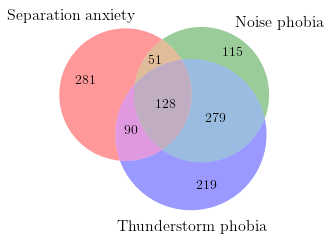

Chi-squared Test of Independence for Thunderstorm phobia, Noise phobia, and Separation anxiety:
chi2 = 285.272663, p = 1.53E-61, dof = 3


In [38]:
labels = ['Thunderstorm phobia', 'Noise phobia', 'Separation anxiety']
contingency = pd.crosstab(df[labels[2]], [df[labels[0]], df[labels[1]]])

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[2]: contingency[0][0][1],
     labels[1]: contingency[1][0][0],
     'Separation-Noise': contingency[1][0][1],
     labels[0]: contingency[0][1][0],
     'Separation-Thunderstorm': contingency[0][1][1],
     'Noise-Thunderstorm': contingency[1][1][0],     
     'All': contingency[1][1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
v = venn3(cross_sums, set_labels=[cross_sums.index.values[i] for i in [0, 1, 3]])
lbl = v.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((x+0.25, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_1')
plt.show()

# Execute a chi-squared test of independence.
print('Chi-squared Test of Independence for %s, %s, and %s:' %(labels[0], labels[1], labels[2]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))

## <center>Separation Anxiety, Destructive Behavior, and House Soiling</center>

### Destruction and separation anxiety:

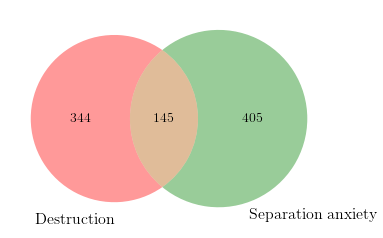

Chi-square Test of Independence:
chi2 = 127.052083, p = 1.81E-29, dof = 1
OR = 3.35, 95% CI: 2.69-4.18, n = 4114


In [39]:
fields = 'q02_main_9, q04_9'
labels = ['Destruction', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Cross tabulate the relevant columns.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('B')
x, y = lbl.get_position()
lbl.set_position((x+0.15, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

### House soiling during owner absence and separation anxiety:

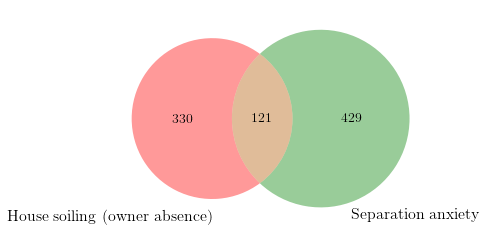

Chi-square Test of Independence:
chi2 = 79.239289, p = 5.50E-19, dof = 1
OR = 2.76, 95% CI: 2.19-3.48, n = 4114


In [40]:
fields = 'q06_situation_2, q04_9'
labels = ['House soiling (owner absence)', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Cross tabulate the relevant columns.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('B')
x, y = lbl.get_position()
lbl.set_position((x+0.15, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

## <center>Fear/Anxiety and House Soiling</center>

## <center>Fear/Anxiety and Aggression</center>

### Overall aggression and fearful/anxious behavior (Figure 2):

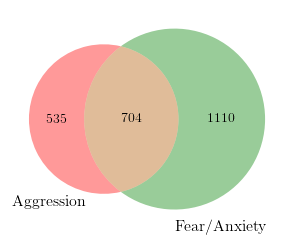

Chi-square Test of Independence:
chi2 = 116.490685, p = 3.71E-27, dof = 1
OR = 2.09, 95% CI: 1.83-2.40, n = 4114


In [41]:
fields = 'q02_main_1, q02_main_2'
labels = ['Aggression', 'Fear/Anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    
# Create a contingency table.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((x-0.1, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_2')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

### Owner directed aggression and fearful/anxious behavior (Figure 3):

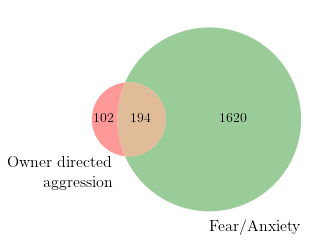

Chi-square Test of Independence:
chi2 = 59.514770, p = 1.21E-14, dof = 1
OR = 2.58, 95% CI: 2.01-3.31, n = 4114


In [42]:
fields = 'q03_main_1, q02_main_2'
labels = ['Owner directed\naggression', 'Fear/Anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    
# Create a contingency table.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((x-0.1, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_3')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

### Owner directed aggression and separation anxiety (Figure 4):

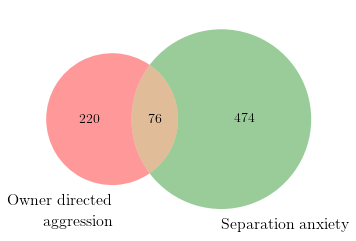

Chi-square Test of Independence:
chi2 = 41.709109, p = 1.06E-10, dof = 1
OR = 2.44, 95% CI: 1.85-3.22, n = 4114


In [43]:
fields = 'q03_main_1, q04_9'
labels = ['Owner directed\naggression', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    
# Create a contingency table.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_4')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

## <center>Fear/Anxiety and Compulsive Behavior</center>

### Fear/anxiety and compulsion (Figure 5):

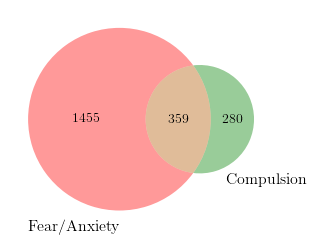

Chi-square Test of Independence:
chi2 = 44.843203, p = 2.13E-11, dof = 1
OR = 1.78, 95% CI: 1.50-2.11, n = 4114


In [44]:
fields = 'q02_main_2, q02_main_3'
labels = ['Fear/Anxiety', 'Compulsion']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Cross tabulate the relevant columns.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('B')
x, y = lbl.get_position()
lbl.set_position((x+0.15, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_5')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

## <center>Coprophagia and Age</center>

In [45]:
fields = 'q02_main_8, q01_age_months'
labels = [FR.categories[7], 'age']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
df = df[np.isfinite(df['age'])]

# Sort ages into two groups:
# 0: age <= 12 months
# 1: age > 12 months
def age_sort(row):
    if row['age'] <= 12:
        val = 0
    else:
        val = 1
    return val

df['age'] = df.apply(age_sort, axis=1)

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

Chi-square Test of Independence:
chi2 = 0.670896, p = 4.13E-01, dof = 1
OR = 0.85, 95% CI: 0.57-1.26, n = 650


## <center>Overactivity/Hyperactivity and Age</center>

In [46]:
fields = 'q02_main_13, q01_age_months'
labels = [FR.categories[11], 'age']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
df = df[np.isfinite(df['age'])]

# Sort ages into two groups:
# 0: age <= 12 months
# 1: age > 12 months
def age_sort(row):
    if row['age'] <= 12:
        val = 0
    else:
        val = 1
    return val

df['age'] = df.apply(age_sort, axis=1)

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

Chi-square Test of Independence:
chi2 = 16.993133, p = 3.75E-05, dof = 1
OR = 0.39, 95% CI: 0.24-0.61, n = 650


## <center>Bite Severity</center>

### Prevalence of biting:

In [47]:
fields = 'q03_form_5'
labels = ['bites']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

tot = df.sum()
print('Dogs that bite: n = %d dogs (%d%%)' %(tot, round((tot/REMAINING_DOGS)*100, 0)))

Dogs that bite: n = 385 dogs (9%)


### Breakdown of bite severity:

In [48]:
fields = 'q03_severity'
labels = ['severity']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: 'count'}, inplace=True)
df.columns.name = labels[0]
for index, row in df.iterrows():
    print('bite level %s: n = %d (%d%%)' %(index, (row[0]), round((row[0]/df['count'].sum())*100, 0)))
    


bite level 3.0: n = 182 (49%)
bite level 2.0: n = 119 (32%)
bite level 4.0: n = 41 (11%)
bite level 1.0: n = 20 (5%)
bite level 5.0: n = 13 (3%)


### Bite severity by behavior problem:

In [49]:
fields = []
labels = []
for counter, cat in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)
fields.append('q03_severity')
labels.append('severity')
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)


rngs = []
rngs.append(df[(df['severity'] == 1)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 2)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 3)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 4)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 5)].drop(columns=['severity']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    #df = df.sum().apply(lambda x: (x / 1))
    return df.round(2)

prevs = []
prevs.append(get_group_prevalence(rngs[0]))
prevs.append(get_group_prevalence(rngs[1]))
prevs.append(get_group_prevalence(rngs[2]))
prevs.append(get_group_prevalence(rngs[3]))
prevs.append(get_group_prevalence(rngs[4]))

df = pd.DataFrame(index=prevs[0].index, data={'level 1': prevs[0], 'level 2': prevs[1], 'level 3': prevs[2],
                                                   'level 4': prevs[3], 'level 5': prevs[4]})
df.columns.name = 'Behavior problem'
display(df)

Behavior problem,level 1,level 2,level 3,level 4,level 5
Aggression,100.0,100.00,100.00,100.00,100.00
Fear/Anxiety,55.0,57.14,64.29,46.34,84.62
Compulsion,25.0,18.49,25.27,12.20,38.46
House Soiling,35.0,26.05,20.33,21.95,23.08
Excessive Barking,40.0,26.89,30.22,26.83,38.46
Jumping,30.0,36.97,34.62,39.02,7.69
Mounting/Humping,5.0,19.33,15.93,12.20,0.00
Coprophagia,15.0,20.17,22.53,24.39,7.69
Destructive Behavior,15.0,12.61,15.93,19.51,15.38
Rolling in Repulsive Material,25.0,22.69,15.38,9.76,23.08


### Bite severity and fear/anxiety:

In [50]:
fields = ', '.join(FR.fields[FR.categories[1]])
labels = list(FR.labels[FR.categories[1]].values())
fields += ', q03_severity'
labels.append('severity')
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

rngs = []
rngs.append(df[(df['severity'] == 1)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 2)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 3)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 4)].drop(columns=['severity']))
rngs.append(df[(df['severity'] == 5)].drop(columns=['severity']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

prevs = []
prevs.append(get_group_prevalence(rngs[0]))
prevs.append(get_group_prevalence(rngs[1]))
prevs.append(get_group_prevalence(rngs[2]))
prevs.append(get_group_prevalence(rngs[3]))
prevs.append(get_group_prevalence(rngs[4]))

df = pd.DataFrame(index=prevs[0].index, data={'level 1': prevs[0], 'level 2': prevs[1], 'level 3': prevs[2],
                                                   'level 4': prevs[3], 'level 5': prevs[4]})
df.columns.name = 'Behavior problem'
display(df)

Behavior problem,level 1,level 2,level 3,level 4,level 5
Thunderstorm phobia,5.0,21.85,24.18,14.63,38.46
Noise phobia,10.0,23.53,29.67,14.63,30.77
Crowd phobia,20.0,31.09,29.12,29.27,46.15
Phobia of other dogs,20.0,14.29,18.68,9.76,30.77
PTSD,10.0,4.20,9.34,14.63,23.08
Generalized anxiety,10.0,13.45,20.88,19.51,53.85
Situational anxiety,25.0,27.73,32.97,31.71,53.85
Veterinarian phobia,25.0,24.37,32.97,21.95,30.77
Separation anxiety,15.0,19.33,24.18,12.20,53.85
Travel anxiety,20.0,12.61,17.58,7.32,38.46


### Bite severity and gender and neutered status:

In [51]:
fields = ['q03_severity']
labels = ['severity']
fields.extend(('dog_sex', 'dog_spayed'))
labels.extend(('Gender', 'Neutered'))
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

df['level 1'] = np.where(df['severity'] == 1, 1, 0)
df['level 2'] = np.where(df['severity'] == 2, 1, 0)
df['level 3'] = np.where(df['severity'] == 3, 1, 0)
df['level 4'] = np.where(df['severity'] == 4, 1, 0)
df['level 5'] = np.where(df['severity'] == 5, 1, 0)
df = df.drop(columns=['severity'])


df_intact_male = df[(df['Gender'] == 1) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_male = df[(df['Gender'] == 1) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])
df_intact_female = df[(df['Gender'] == 2) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_female = df[(df['Gender'] == 2) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])

def get_group_prevalence(df):
    #df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    df = df.sum().apply(lambda x: (x / 1))
    return df.round(2)

intact_male_p = get_group_prevalence(df_intact_male)
neutered_male_p = get_group_prevalence(df_neutered_male)
intact_female_p = get_group_prevalence(df_intact_female)
neutered_female_p = get_group_prevalence(df_neutered_female)

df = pd.DataFrame(index=intact_male_p.index, data={'Intact males': intact_male_p,
                                                   'Castrated males': neutered_male_p,
                                                   'Intact females': intact_female_p,
                                                   'Spayed females': neutered_female_p})
df.columns.name = 'Behavior problem'
display(df)

# by hand: 3.504043127	52.83018868	3.234501348	40.43126685	100

Behavior problem,Intact males,Castrated males,Intact females,Spayed females
level 1,1.0,10.0,1.0,8.0
level 2,3.0,64.0,5.0,45.0
level 3,5.0,97.0,4.0,74.0
level 4,4.0,18.0,1.0,18.0
level 5,0.0,7.0,1.0,5.0


## <center>Appendix</center>

### Behavior problem category heat map (Appendix 2):

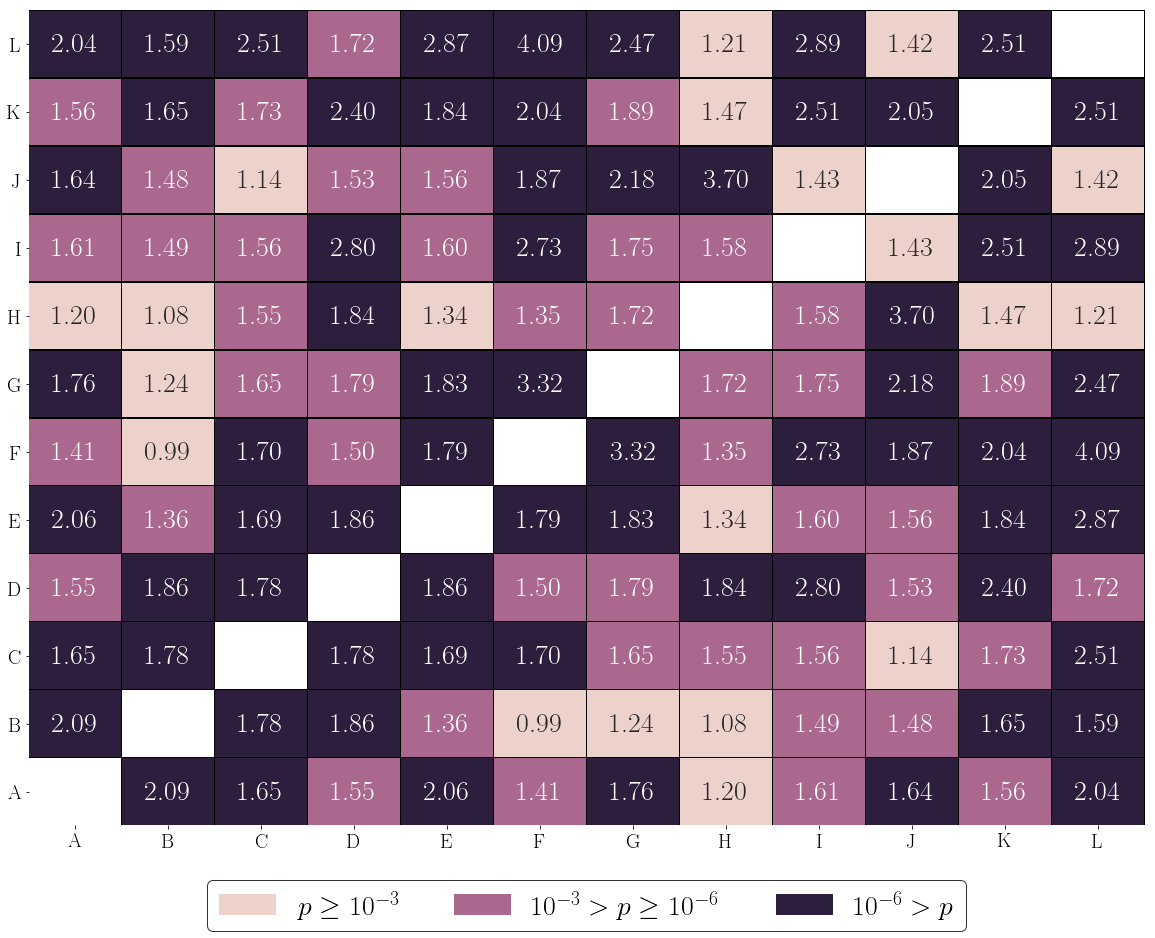

In [52]:
if CATEGORY_MATRIX.empty:
    CATEGORY_MATRIX = createCategoryMatrix()
df = CATEGORY_MATRIX.applymap(lambda row: get_significance_category(row))
df_or = createOddsRatioMatrix()

# Heatmap
fig, ax = plt.subplots(figsize=(20, 15))
cmap = sns.cubehelix_palette(n_colors=3)
ax = sns.heatmap(data=df, ax=ax, cmap=ListedColormap(cmap), linewidths=0.5, linecolor='black',
                 cbar=False, mask=df.isnull(), annot=df_or, annot_kws={"size": 28}, fmt='.2f')
plt.xticks(rotation=0, fontsize=20)
plt.yticks(rotation=0, fontsize=20)
ax.invert_yaxis()
import matplotlib.patches as mpatches
patch_1 = mpatches.Patch(color=cmap[0], label='$p\geq10^{-3}$')
patch_2 = mpatches.Patch(color=cmap[1], label='$10^{-3}>p\geq10^{-6}$')
patch_3 = mpatches.Patch(color=cmap[2], label='$10^{-6}>p$')
legend = plt.legend(handles=[patch_1, patch_2, patch_3], bbox_to_anchor=(0.5, -0.05), loc='upper center',
                    fontsize=28, ncol=3)
legend.get_frame().set_edgecolor('black')
exportFigure(fig, 'figure_6')
plt.show()

### Heat map axes abbrevation reference chart (Appendix 3):

In [53]:
cat_dict = {}
for cat, subdict in FR.labels.items():
    for key, value in  subdict.items():
        cat_dict[key[0]] = cat
        break

s = pd.Series(cat_dict)
df = pd.DataFrame(index=s.index, data={'Category':s.values})
df.columns.name = 'Index'
display(df)
exportTable(df, 'table_category_reference')

Index,Category
A,Aggression
B,Fear/Anxiety
C,Compulsion
D,House Soiling
E,Excessive Barking
F,Jumping
G,Mounting/Humping
H,Coprophagia
I,Destructive Behavior
J,Rolling in Repulsive Material
